# Question 4

Does unit price impact how much a customer spends? At what levels? How about quantity that a customer orders?

I want to know if customers spend differently based on the unit price. Customers may buy higher quantities when unit price is low, or conversely purchase lower quantities when unit price is high. If this is the case, revenue per order may not be significantly different.

In [1]:
#import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#For KS Test
from scipy import stats

#For Sampling, Welch's T-Test, Cohen's d - flatiron_stats.py. I have updated with my own functions.
from flatiron_stats import p_value_welch_ttest, welch_t, cohens_d, get_sampling_means

#For SQL Helpter functions
from flatiron_sql import view_table, get_table, get_table_names

#For Power Analysis
from statsmodels.stats.power import TTestIndPower, TTestPower

#significance level
alpha = 0.05

In [2]:
#connect to the Northwind database
conn = sqlite3.connect("Northwind_small.sqlite")

### Initial investigation into Data

I want to get the **UnitPrice**, **Quantity**, **TotalPrice** (total for an item in an order), and the **Customer** who made the purchase.

**TotalPrice is feature engineered through the SQL Query**

In [3]:
#Tables needed: OrderDetail, Order (customerID is sufficient for grouping by customer)
query = """SELECT od.Id, o.CustomerId, od.UnitPrice, od.Quantity, 
                  od.UnitPrice * od.Quantity * (1-od.Discount) AS TotalPrice
           FROM 
           OrderDetail od JOIN 'Order' o ON o.Id=od.OrderId
           """
df = pd.read_sql(query,conn)
df.head()

,Id,CustomerId,UnitPrice,Quantity,TotalPrice
0,10248/11,VINET,14.0,12,168.0
1,10248/42,VINET,9.8,10,98.0
2,10248/72,VINET,34.8,5,174.0
3,10249/14,TOMSP,18.6,9,167.4
4,10249/51,TOMSP,42.4,40,1696.0


In [4]:
df.UnitPrice.describe()

count    2155.000000
mean       26.218520
std        29.827418
min         2.000000
25%        12.000000
50%        18.400000
75%        32.000000
max       263.500000
Name: UnitPrice, dtype: float64

**Unit Prices range from 2 to 263. The breakdown into quartiles is as follows:**

- 0_25  = less than or equal to 12
- 25_50 = Between 12 and 18.4
- 50_75 = Between 18.4 and 32
- 75_100 = greater than 32


**Feature Engineering** - add unit price quartile column to dataframe

In [5]:
def get_quartile(value,qt25,qt50,qt75):
    if value <= qt25:
        return "0_25"
    elif value <=qt50:
        return "25_50"
    elif value <=qt75:
        return "50_75"
    else:
        return "75_100"

In [6]:
qt25 = df.UnitPrice.quantile(0.25)
qt50 = df.UnitPrice.quantile(0.5)
qt75 = df.UnitPrice.quantile(0.75)
df['UnitPriceQuartile'] = [get_quartile(x, qt25, qt50, qt75) for x in df.UnitPrice]

In [7]:
df.head()

,Id,CustomerId,UnitPrice,Quantity,TotalPrice,UnitPriceQuartile
0,10248/11,VINET,14.0,12,168.0,25_50
1,10248/42,VINET,9.8,10,98.0,0_25
2,10248/72,VINET,34.8,5,174.0,75_100
3,10249/14,TOMSP,18.6,9,167.4,50_75
4,10249/51,TOMSP,42.4,40,1696.0,75_100


## Visualize the Data

### Total Order Price
Broken down by unit price quartile

It looks like a positive correlation between unit price and total order price. Tests are in later sections that determine if statistically significant.

Text(0, 0.5, 'Total Order Price')

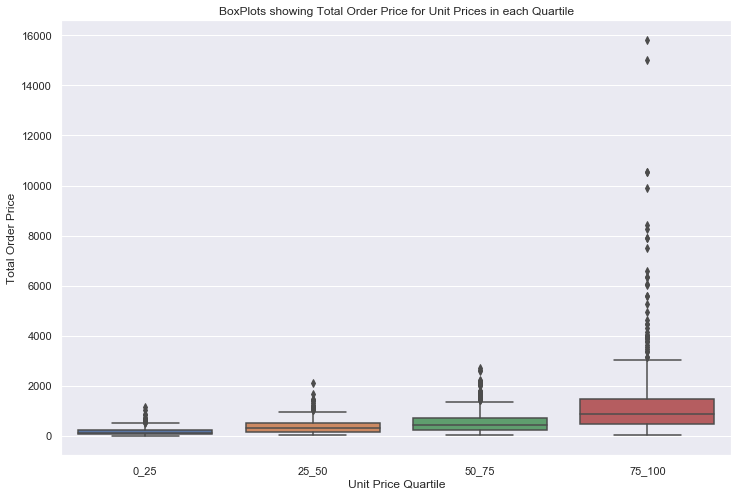

In [8]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='UnitPriceQuartile',y='TotalPrice',data=df)
plt.title('BoxPlots showing Total Order Price for Unit Prices in each Quartile')
plt.xlabel('Unit Price Quartile');
plt.ylabel('Total Order Price')

Text(0, 0.5, 'Total Order Price')

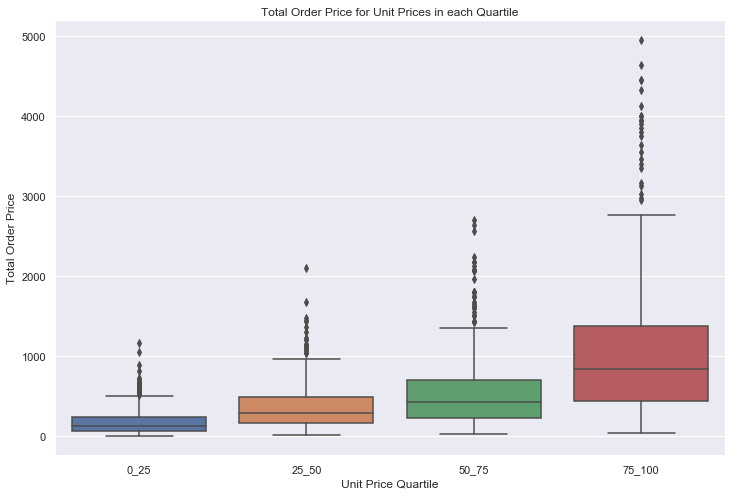

In [9]:
df = df[df.TotalPrice<5000]
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='UnitPriceQuartile',y='TotalPrice',data=df)
plt.title('Total Order Price for Unit Prices in each Quartile')
plt.xlabel('Unit Price Quartile');
plt.ylabel('Total Order Price')

### Quantity Ordered
Broken down by unit price quartile.

The data looks to be very similar across unit prices... meaning that the unit price does not seem to affect quantity ordered. Tests are in later sections that determine if there is a statistically significant difference between groups.

Text(0, 0.5, 'Total Order Quantity')

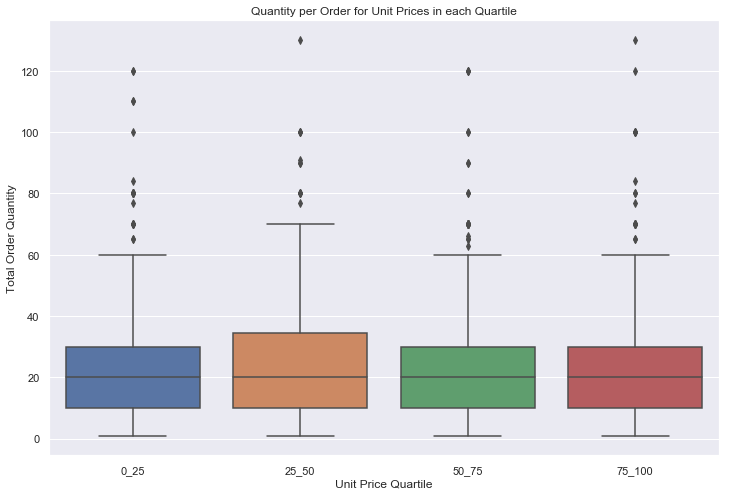

In [10]:
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x='UnitPriceQuartile',y='Quantity',data=df)
plt.title('Quantity per Order for Unit Prices in each Quartile')
plt.xlabel('Unit Price Quartile');
plt.ylabel('Total Order Quantity')

## ANOVA Test

### ANOVA Test for **Total Order Price**

**Reject Null Hypothesis**

In [11]:
#ANOVA TEST
formula = "TotalPrice ~ C(UnitPriceQuartile)"
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table['reject_null'] = table['PR(>F)'] < alpha
print(table)

                            sum_sq      df           F         PR(>F)  \
C(UnitPriceQuartile)  2.300110e+08     3.0  296.780187  5.381406e-161   
Residual              5.510402e+08  2133.0         NaN            NaN   

                      reject_null  
C(UnitPriceQuartile)         True  
Residual                    False  


### ANOVA Test for **Order Quantity**

**Fail to Reject Null Hypothesis**

In [12]:
#ANOVA TEST
formula = "Quantity ~ C(UnitPriceQuartile)"
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
table['reject_null'] = table['PR(>F)'] < alpha
print(table)

                             sum_sq      df         F    PR(>F)  reject_null
C(UnitPriceQuartile)     745.434750     3.0  0.714806  0.543094        False
Residual              741465.475872  2133.0       NaN       NaN        False


## Tukey Test
Unit Price quartiles comparison

### Tukey Test for **Total Order Price**

**Reject Null Hypothesis** for all pairwise comparisons.

In [13]:
#TUKEY TEST
mc = MultiComparison(df['TotalPrice'], df['UnitPriceQuartile'])
result = mc.tukeyhsd()
print("Groups are Unit Price Quartiles, summary stats are TotalPrice per Order\n")
#Convert result to dataframe for prettiness and to only show the comparisons that include no-discount
result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
print("Multiple Comparison of Means - Tukey HSD,FWER=0.05")
#result_df.rename(columns={'group1': 'NoDiscount', 'group2': 'Discount'}, inplace=True)
result_df

Groups are Unit Price Quartiles, summary stats are TotalPrice per Order

Multiple Comparison of Means - Tukey HSD,FWER=0.05


,group1,group2,meandiff,lower,upper,reject
0,0_25,25_50,179.8898,100.7609,259.0187,True
1,0_25,50_75,365.3178,285.8534,444.7821,True
2,0_25,75_100,885.2133,804.9669,965.4598,True
3,25_50,50_75,185.4280,105.7112,265.1447,True
4,25_50,75_100,705.3236,624.8272,785.8200,True
5,50_75,75_100,519.8956,439.0694,600.7218,True


### Tukey Test for **Quantity**

**Fail to reject Null Hypothesis** for all pairwise comparisons.

In [14]:
#TUKEY TEST
mc = MultiComparison(df['Quantity'], df['UnitPriceQuartile'])
result = mc.tukeyhsd()
print("Groups are Unit Price Quartiles, summary stats are Quantity per Order\n")
#Convert result to dataframe for prettiness and to only show the comparisons that include no-discount
result_df = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
print("Multiple Comparison of Means - Tukey HSD,FWER=0.05")
#result_df.rename(columns={'group1': 'NoDiscount', 'group2': 'Discount'}, inplace=True)
result_df

Groups are Unit Price Quartiles, summary stats are Quantity per Order

Multiple Comparison of Means - Tukey HSD,FWER=0.05


,group1,group2,meandiff,lower,upper,reject
0,0_25,25_50,1.4359,-1.4667,4.3386,False
1,0_25,50_75,0.4946,-2.4203,3.4096,False
2,0_25,75_100,-0.0108,-2.9544,2.9328,False
3,25_50,50_75,-0.9413,-3.8655,1.9829,False
4,25_50,75_100,-1.4468,-4.3995,1.5060,False
5,50_75,75_100,-0.5055,-3.4703,2.4594,False


## Histogram of Distributions

In [15]:
unit_quartiles = list(df.UnitPriceQuartile.unique())
unit_quartiles

['25_50', '0_25', '75_100', '50_75']

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


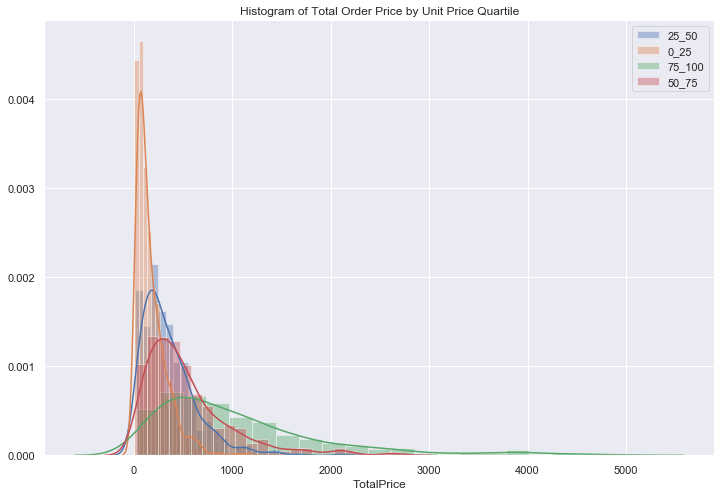

In [16]:
sns.set(rc={'figure.figsize':(12,8)})
for quartile in unit_quartiles:
    sns.distplot(df.TotalPrice[df.UnitPriceQuartile==quartile], label=quartile)
plt.title('Histogram of Total Order Price by Unit Price Quartile')
plt.legend()

/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


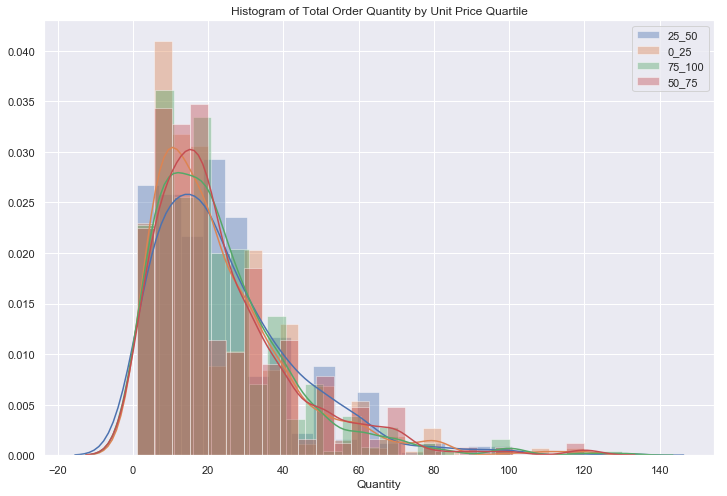

In [17]:
sns.set(rc={'figure.figsize':(12,8)})
for quartile in unit_quartiles:
    sns.distplot(df.Quantity[df.UnitPriceQuartile==quartile], label=quartile)
plt.title('Histogram of Total Order Quantity by Unit Price Quartile')
plt.legend()

## Effect Size

Calculate effect size for each quartile compared to the rest of the data.
The results indicate that the smallest and largest unit prices have the greatest effect on total order price. This is not surprising since we learned that quantity ordered is not impacted by unit price. Therefore, the lowest and highest unit prices will be furthest from the mean order price.

In [18]:
for quartile in unit_quartiles:
    quartile_data = df.TotalPrice[df.UnitPriceQuartile==quartile]
    remaining_data = df.TotalPrice[df.UnitPriceQuartile!=quartile]
    d = cohens_d(quartile_data,remaining_data)
    mean_diff = abs(quartile_data.mean() - remaining_data.mean())
    print("Effect Size d for {}: {}   mean difference: {}".format(quartile,round(d,3),round(mean_diff,3)))

Effect Size d for 25_50: 0.38   mean difference: 226.899
Effect Size d for 0_25: 0.826   mean difference: 469.981
Effect Size d for 75_100: 1.345   mean difference: 705.278
Effect Size d for 50_75: 0.035   mean difference: 21.418


## Conclusion
Quantity per order is pretty consistent across different price levels. This is interesting because it almost indicates a certain level of price inelasticity. Or possibly that orders are tied to retail sales and inventory counts -- unit price does not matter in this case.

Higher unit prices equate to higher overall order revenue. Customers do not purchase smaller quantities for higher priced items.

### Some Visualization of the Data in a Different Way

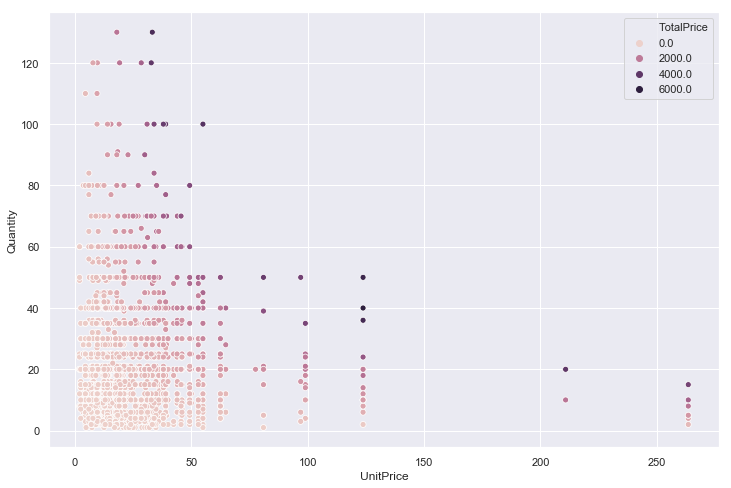

In [19]:
sns.scatterplot('UnitPrice','Quantity',hue='TotalPrice',data=df)

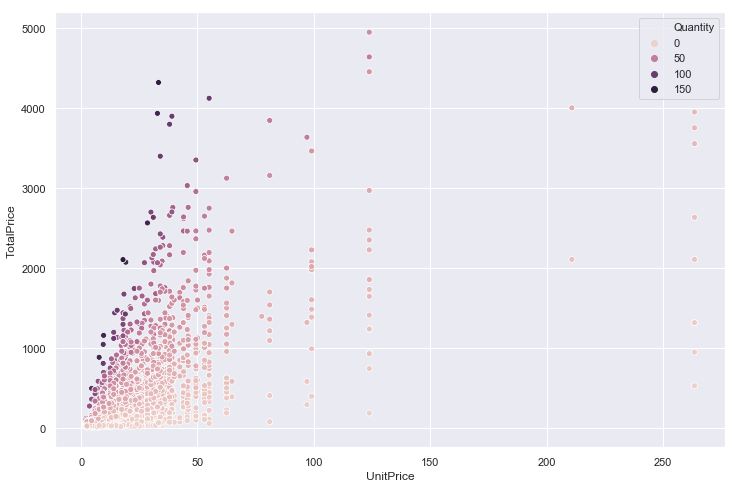

In [20]:
sns.scatterplot('UnitPrice','TotalPrice',hue="Quantity",data=df)